## Project Description

This month Model Fitness lost 26.5% of its customers. If we don't balance out this share by acquiring new customers, the company will become less profitable. As such, it is a no-brainer to develop strategies to prevent customer churn as well as possible. The very first step in this endeavour is to single out the warning signs that a customer will be lost.

A straightforward approach to solving problems like this is using modern Machine Learning techniques. In this report, I will guide the reader through the development of a classification model that enables Model Fitness to predict the probability of a customer to churn in the upcoming month. In the next step, I will divide our customers into five clusters which will allow us to develop group-based countermeasures based on the customers' specific risk profiles. Finally, I will present a set of possible actions that can be taken to reduce customer churn to a minimum.

**Description of the data**  
`/datasets/gym_churn_us.csv`

* 'Churn' — the fact of churn for the month in question  
Current dataset fields:
User data for the preceding month
   * 'gender'
   * 'Near_Location' — whether the user lives or works in the neighborhood where the gym is located
   * 'Partner' — whether the user is an employee of a partner company (the gym has partner companies whose employees get discounts; in those cases the gym stores information on customers' employers)
   * Promo_friends — whether the user originally signed up through a "bring a friend" offer (they used a friend's promo code when paying for their first membership)
   * 'Phone' — whether the user provided their phone number
   * 'Age'
   * 'Lifetime' — the time (in months) since the customer first came to the gym  
    
Data from the log of visits and purchases and data on current membership status  
   * 'Contract_period' — 1 month, 3 months, 6 months, or 1 year
   * 'Month_to_end_contract' — the months remaining until the contract expires
   * 'Group_visits' — whether the user takes part in group sessions
   * 'Avg_class_frequency_total' — average frequency of visits per week over the customer's lifetime
   * 'Avg_class_frequency_current_month' — average frequency of visits per week over the preceding month
   * 'Avg_additional_charges_total' — the total amount of money spent on other gym services: cafe, athletic goods, cosmetics, massages, etc.

## Table of contents

<a href="#Step-1.-Download-the-data">Step 1. Download the data<a/>  
    
<a href="#Step-2.-Carry-out-exploratory-data-analysis-(EDA)">Step 2. Carry out exploratory data analysis (EDA)<a/>
* <a href="#Look-at-the-dataset">Look at the dataset</a>    
* <a href="#Look-at-the-mean-feature-values-in-two-groups-(churn-and-non-churn)">Look at the mean feature values in two groups (churn and non-churn)<a/> 
* <a href="#Plot-bar-histograms-and-feature-distributions-for-those-who-left-(churn)-and-those-who-stayed">Plot bar histograms and feature distributions for those who left (churn) and those who stayed</a>
* <a href="#Build-a-correlation-matrix">Build a correlation matrix</a>

<a href="#Step-3.-Build-a-model-to-predict-user-churn">Step 3. Build a model to predict user churn<a/>
* <a href="#Divide-the-data-into-train-and-validation-sets">Divide the data into train and validation sets</a>
* <a href="#Train-the-models-with-binary-classification-algorithms">Train the models with binary classification algorithms</a>
    
<a href="#Step-4.-Create-user-clusters">Step 4. Create user clusters<a/>
* <a href="#Standardize-data-and-plot-a-dendrogram">Standardize data and plot a dendrogram</a>
* <a href="#Train-the-clustering-model">Train the clustering model</a>
* <a href="#Look-at-the-mean-feature-values-for-clusters">Look at the mean feature values for clusters</a>
* <a href="#Plot-distributions-of-features-for-each-cluster">Plot distributions of features for each cluster</a>  
* <a href="#Calculate-the-churn-rate-for-each-cluster">Calculate the churn rate for each cluster</a>
    
<a href="#Step-5.-Conclusions-and-basic-recommendations">Step 5. Conclusions and basic recommendations<a/>

In [247]:
pip install scikit-plot --upgrade

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: scikit-plot in /home/jovyan/.local/lib/python3.7/site-packages (0.3.7)
Note: you may need to restart the kernel to use updated packages.


In [248]:
pip install seaborn --upgrade

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: seaborn in /home/jovyan/.local/lib/python3.7/site-packages (0.11.2)
Note: you may need to restart the kernel to use updated packages.


## Step 1. Download the data

In [249]:
# load libraries
import pandas as pd
from IPython.display import display
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import scikitplot as skplt

In [250]:
# load the csv data files to python and convert columns to contain the correct datatype
churn_data = pd.read_csv("/datasets/gym_churn_us.csv", 
                   dtype={'gender':'int32', 'Near_Location':
                          'int32','Partner':'int32', 'Promo_friends': 'int32', 
                          'Phone':'int32','Churn': 'int32', 'Group_visits': 'int32',
                          'Age':'int32','Lifetime': 'int32', 'Contract_period':'int32', 
                          'Avg_additional_charges_total':'float32', 
                          'Month_to_end_contract':'int32', 
                          'Avg_class_frequency_total':'float32', 
                          'Avg_class_frequency_current_month':'float32'})

# converting column names to lower case characters
churn_data.columns = churn_data.columns.str.lower()

# display first five rows
display(churn_data.head())

# display the size of the dataset
display(churn_data.info())

# check for duplicates
display(churn_data.duplicated().sum())

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202934,12,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448486,1,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669865,12,2,3.205633,3.357214,0
4,1,1,1,1,1,1,0,26,198.362259,1,3,1.113884,1.120078,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int32
near_location                        4000 non-null int32
partner                              4000 non-null int32
promo_friends                        4000 non-null int32
phone                                4000 non-null int32
contract_period                      4000 non-null int32
group_visits                         4000 non-null int32
age                                  4000 non-null int32
avg_additional_charges_total         4000 non-null float32
month_to_end_contract                4000 non-null int32
lifetime                             4000 non-null int32
avg_class_frequency_total            4000 non-null float32
avg_class_frequency_current_month    4000 non-null float32
churn                                4000 non-null int32
dtypes: float32(3), int32(11)
memory usage: 218.9 KB


None

0

**Conclusion**

The dataset consists of 4000 rows and 14 columns. All the columns are with quantitative variables. We decided to change the column names to lowercase. We discovered that all columns are in their required data type and there no duplicates in our dataset.

[<a href="#Table-of-contents">Back to top</a>]

## Step 2. Carry out exploratory data analysis (EDA)

### Look at the dataset

In [251]:
# getting the description of the data
display(churn_data.describe().T)

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943726,96.355606,0.148205,68.868832,136.220161,210.949619,552.590759
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


**Conclusion**

From the description of the data, we discovered that there are no missing values in the dataset. Column `Churn` has a mean of about 0.27 and standard deviation of about 0.44. Since the values of `Churn` is binary (that is, either 0 or 1), this means that on average, about 27% of customers churn.  
The average age among our customers is about 29 years with a standard deviation of about 3.3. The youngest customer is 18 years old and the elderst is 41 years old. On average, contracts last for about 5 months. The longest a customer has ever stayed with the gym is 31 months and the shortest is less than a month. On average, the average additional charges is about 146.94 US dollars with a standard deviation of about 96.4.

[<a href="#Table-of-contents">Back to top</a>]

### Look at the mean feature values in two groups (churn and non-churn)

In [252]:
# calculating the proportions of churn
display((round(churn_data["churn"].value_counts()/data.shape[0],2)).to_frame("Churn Proportions"))

,Churn Proportions
0,0.73
1,0.27


In [253]:
# grouping dataset by 'churn'
churn_group = data.groupby("churn").mean().reset_index()
display(churn_group)

,churn,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,cluster_km
0,0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445709,5.283089,4.711807,2.024876,2.027882,1.823069
1,1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082901,1.662582,0.990575,1.474995,1.044546,1.404336


**Conclusion**

When considering gender, churn customers and non-churn customers have the same mean of 0.51. Churn customers who resided near the gym had a mean of 0.76, whereas non-churn customers had a mean of 0.87. Churn customers are on average 27 years old, while non-churn customers are on average 30 years old. This implies that younger people are more likely than older people to abandon the gym. Non-churn clients have an average lifetime of roughly 5 months, while churn customers have an average lifetime of less than a month. Customers who stayed paid an average of 158.45 dollars more in total additional charges than those who left (about 115.08).

[<a href="#Table-of-contents">Back to top</a>]

### Plot bar histograms and feature distributions for those who left (churn) and those who stayed

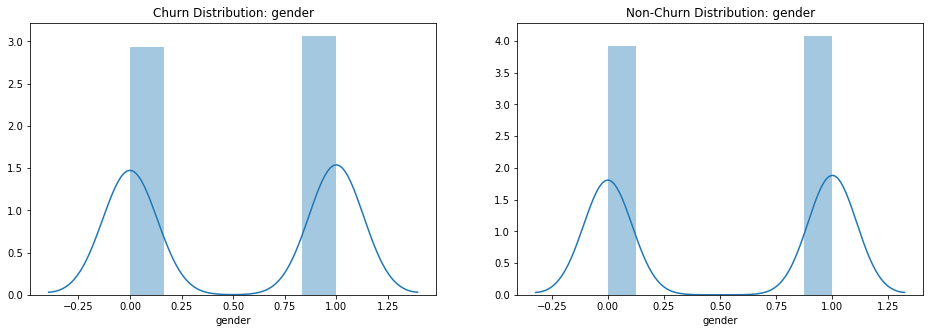

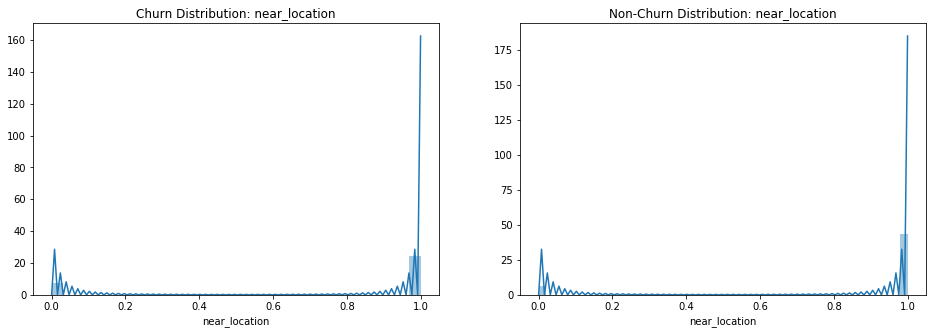

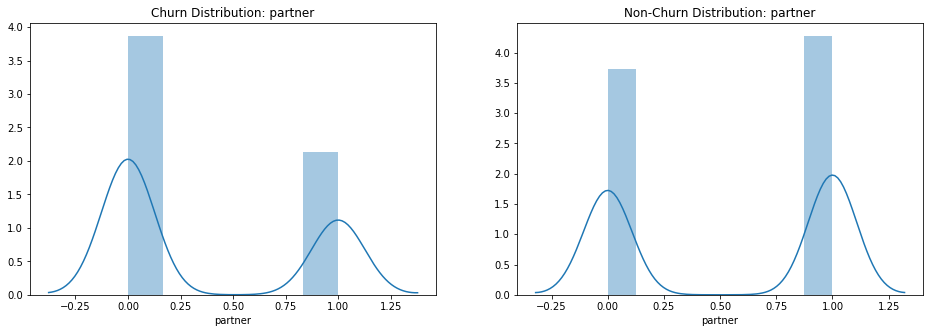

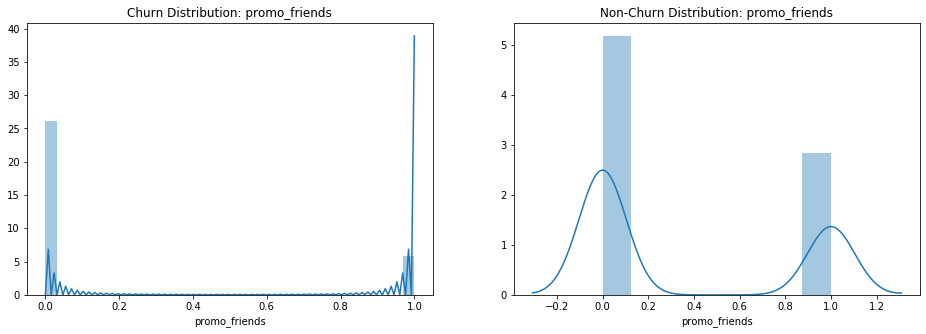

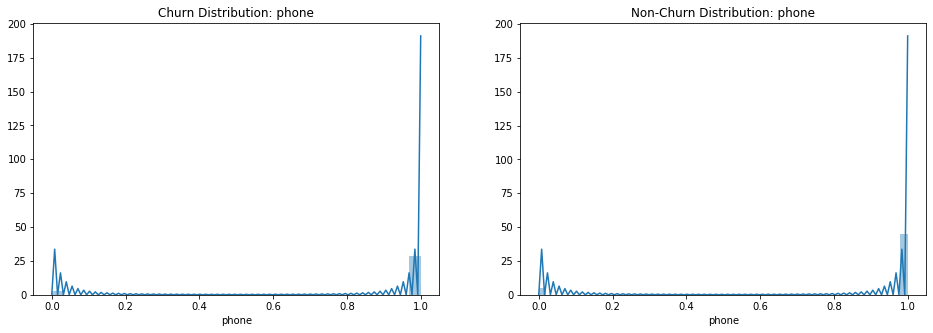

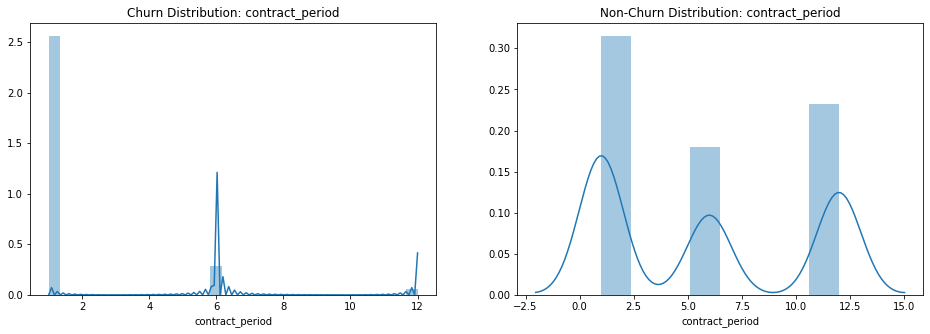

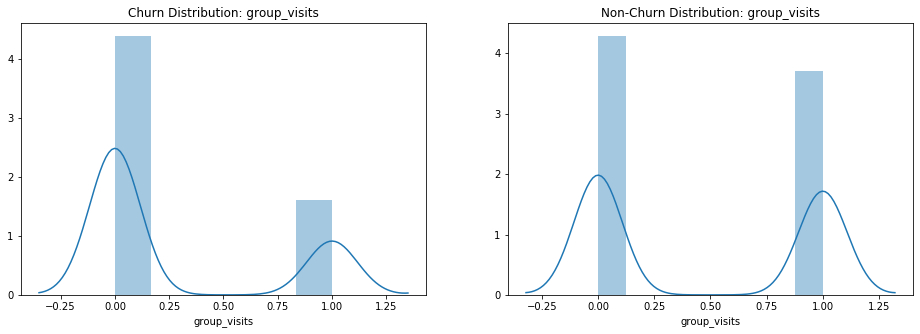

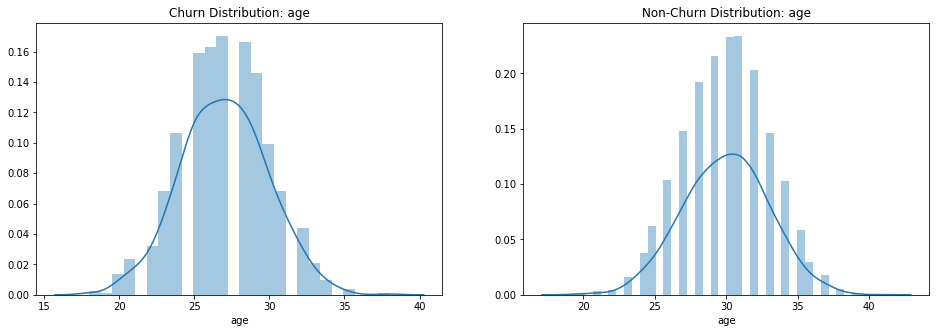

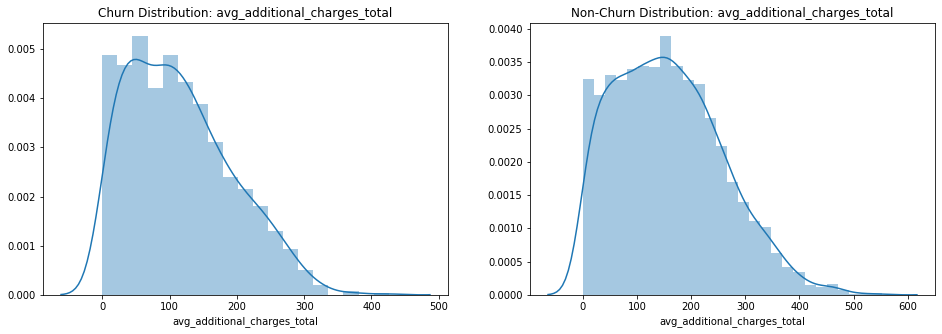

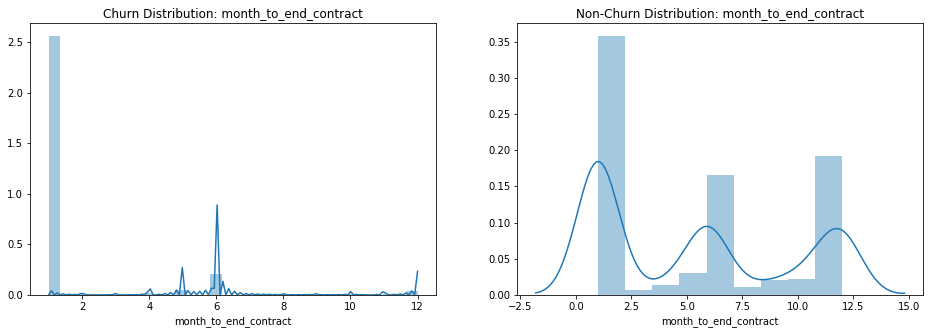

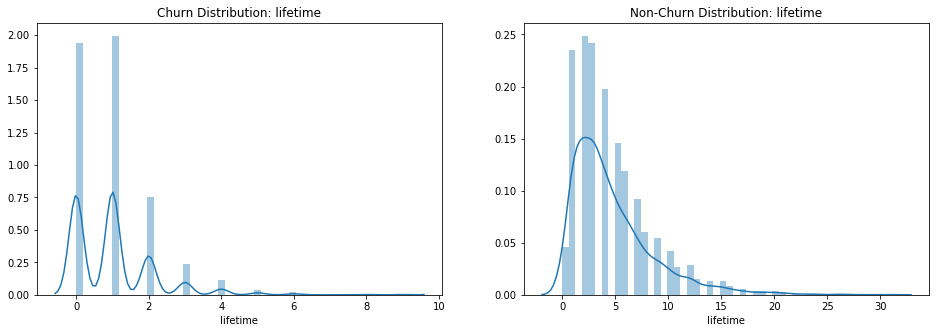

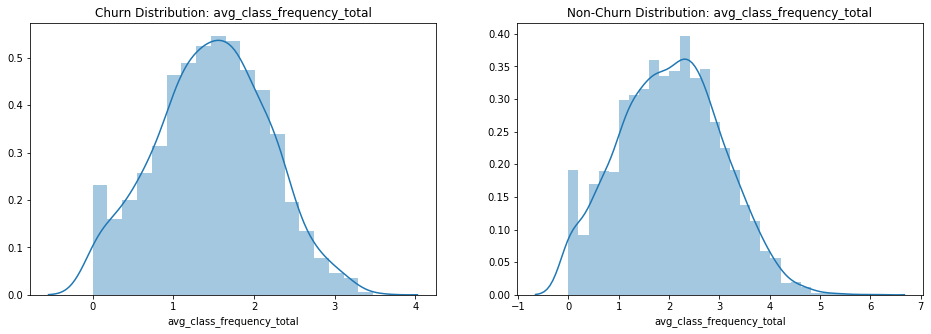

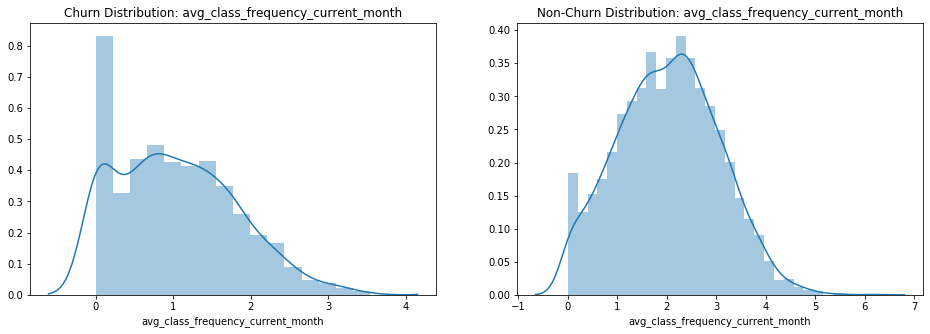

In [254]:
# plotting distributions for each feature
churned = churn_data.query('churn == 1').drop('churn', axis=1)
non_churned = churn_data.query('churn == 0').drop('churn', axis=1)

for col in churned.columns:
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    axes = axes.reshape(-1)
    
    axes[0].set_title('Churn Distribution: {}'.format(str(col)))
    axes[1].set_title('Non-Churn Distribution: {}'.format(str(col)))
    
    sns.distplot(churned[col], ax=axes[0], hist_kws={'density': True}, fit=None)
    sns.distplot(non_churned[col], ax=axes[1], hist_kws={'density': True}, fit=None)
    plt.show()

**Conclusion**

We discovered that the share of gender, age, whether users provided their phone number, and whether users live near the gym do not vary much between churn and non-churn customers ( that is, the share is almost the same). But generally, customers who live near the gym are five times more than customers who do not for both group.  
Non-churn customers are more likely to to be an employee of a partner company than churn customers. Non-churn customers are more likely to have originally signed up through a 'bring a friend' offer.  
However, customers who join gym via promo friends are less likely to churn than those who join without a promo friend. Churn customers on average, have a smaller contract period than non-churn customers. Non-churn customers are more likely to take part in group sessions.  The churn distribution with regards to age is approximately normally distributed. Younger people are more likely to churn than older people.

[<a href="#Table-of-contents">Back to top</a>]

### Build a correlation matrix

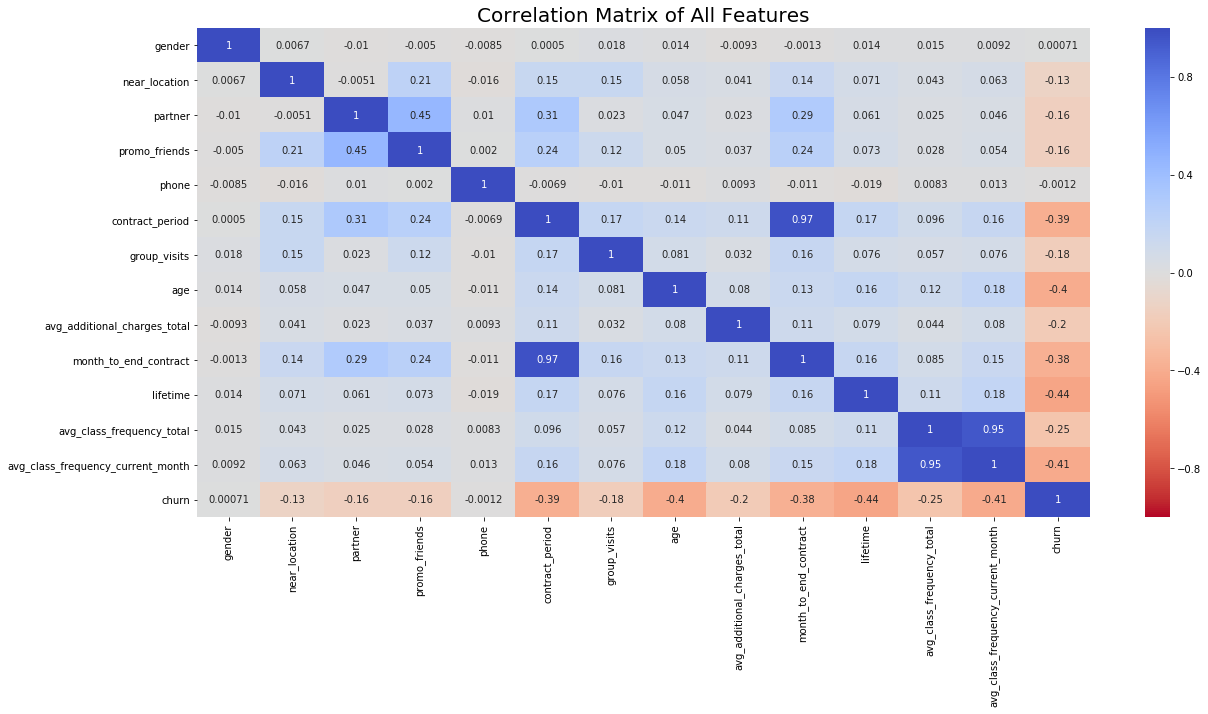

In [255]:
# plotting heatmap of correlation matrix
fig, ax = plt.subplots(figsize = (20, 9))
sns.heatmap(churn_data.corr(), annot= True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm_r')
ax.set_title('Correlation Matrix of All Features', size=20)
plt.show()

In [256]:
# drop two columns from the dataset
churn_data.drop(['avg_class_frequency_current_month', 'month_to_end_contract'], axis=1, inplace= True)

**Conclusion**

We discovered that every other features apart from `gender` are negatively correlated with the target variable (`churn`). The `contract period` and `month_to_end_contract` features are highly correlated with correlation coefficient of 0.97. Also, `avg_class_frequency_current_month` and `avg_class_frequency_total` has a correlation of about 0.95. This high correlation indicates presence of multicollinearity between the variables. 
We decided to drop `avg_class_frequency_current_month` and `month_to_end_contract` features to avoid multicollinearity.

[<a href="#Table-of-contents">Back to top</a>]

## Step 3. Build a model to predict user churn

### Divide the data into train and validation sets

In [257]:
# dividing data into train and validation sets
X = churn_data.drop("churn",axis=1)
y = churn_data["churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [258]:
# standardizing data
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train) 

# applying standardizer to validation set
X_test_st = scaler.transform(X_test)

display(X_train_st[:5], X_test_st[:5])

array([[-1.01511421,  0.4175068 ,  1.03175391,  1.4800097 ,  0.31628211,
         1.60502986, -0.84769226,  0.57944798,  0.37161709,  1.12734972,
         1.75580422],
       [-1.01511421,  0.4175068 , -0.96922337, -0.67567125,  0.31628211,
        -0.81299073, -0.84769226,  0.27046055, -1.09697377,  5.88138322,
        -0.22396739],
       [ 0.98511083,  0.4175068 ,  1.03175391, -0.67567125,  0.31628211,
         1.60502986, -0.84769226, -0.65650171, -1.18374157,  0.3350108 ,
        -0.84308454],
       [-1.01511421,  0.4175068 ,  1.03175391,  1.4800097 ,  0.31628211,
         0.28610954, -0.84769226, -0.96548914, -0.9515883 ,  1.39146269,
         0.66771381],
       [-1.01511421,  0.4175068 , -0.96922337, -0.67567125, -3.16173427,
        -0.81299073, -0.84769226, -0.03852687,  0.97190437,  0.07089783,
        -0.19587937]])

array([[-1.01511421,  0.4175068 ,  1.03175391,  1.4800097 ,  0.31628211,
         1.60502986,  1.17967339, -0.03852687,  1.16533388, -0.45732812,
         0.47975679],
       [-1.01511421, -2.39517058, -0.96922337, -0.67567125,  0.31628211,
        -0.81299073,  1.17967339, -0.65650171, -1.0195379 , -0.98555406,
        -0.90162142],
       [-1.01511421, -2.39517058,  1.03175391, -0.67567125,  0.31628211,
         0.28610954, -0.84769226,  0.27046055, -1.26091494, -0.45732812,
        -1.93212561],
       [ 0.98511083,  0.4175068 , -0.96922337, -0.67567125,  0.31628211,
        -0.81299073,  1.17967339, -0.65650171, -0.07526251, -0.98555406,
         0.45301528],
       [ 0.98511083, -2.39517058,  1.03175391, -0.67567125, -3.16173427,
         1.60502986, -0.84769226, -0.03852687, -0.59196526, -0.72144109,
         1.68492855]])

### Train the models with binary classification algorithms

In [259]:
def make_prediction(model, X_train, y_train, X_test, y_test):
    '''This fuction trains model and prints metrics'''
    model_list = []
    accuracy_list = []
    precision_list = []
    recall_list = []
    
    for model in models:
        model1 = model(random_state=0)
        model1.fit(X_train, y_train)
        y_pred = model1.predict(X_test)
        results = accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred)

        # append data and result to lists
        model_list.append(model)
        accuracy_list.append(results[0])
        precision_list.append(results[1])
        recall_list.append(results[2])
        
        # creating dictionary of results for dataframe
        result_dict = {'model': model_list, 'accuracy score': accuracy_list, 
                       'precision score': precision_list, 'recall score': recall_list}
        
    # return results in dataframe
    return pd.DataFrame(result_dict)

In [260]:
# list of models
models = [LogisticRegression, RandomForestClassifier]

In [261]:
# applying the function
display(make_prediction(models, X_train, y_train, X_test, y_test))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,model,accuracy score,precision score,recall score
0,<class 'sklearn.linear_model.logistic.Logistic...,0.88375,0.761194,0.772727
1,<class 'sklearn.ensemble.forest.RandomForestCl...,0.88000,0.774194,0.727273


**Conclusion**

We built a binary classification model for customers where the target variable is whether or not the user will leave next month. The data was splitted into 80% training and 20% validation set, and we trained two models using `LogisticRegression` and `RandomForestClassifier` algoritms.  
After evaluating accuracy, precision, and recall score for the two models, we discovered that `LogisticRegression` algorithm had slightly better performance on all three metrics.

[<a href="#Table-of-contents">Back to top</a>]

In [262]:
# train LogisticRegresion model and making prediction
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train_st, y_train)
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


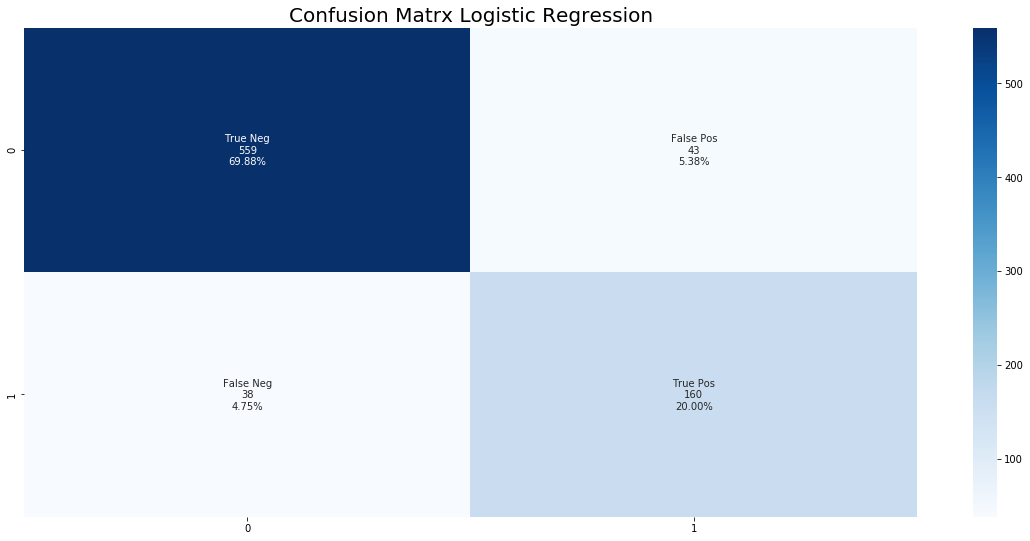

In [263]:
# visualising a confusion matrix for the logistic regression model
fig, ax= plt.subplots(figsize= (20,9))
cf_matrix= skplt.metrics.confusion_matrix(y_test, lr_predictions)

group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

ax.set_title('Confusion Matrx Logistic Regression', size= 20)
plt.show()

**Conclusion**

Out of 602 non-churn customers in the validation data, the model correctly predicted 559 of them (True positive), and wrongly predicted 43 of them (False positive ). Out of the 198 churn customers in the validation data, the model correctly predicted 160 (True positive), and wrongly predicted 38 of them (False negative).

[<a href="#Table-of-contents">Back to top</a>]

## Step 4. Create user clusters

### Standardize data and plot a dendrogram

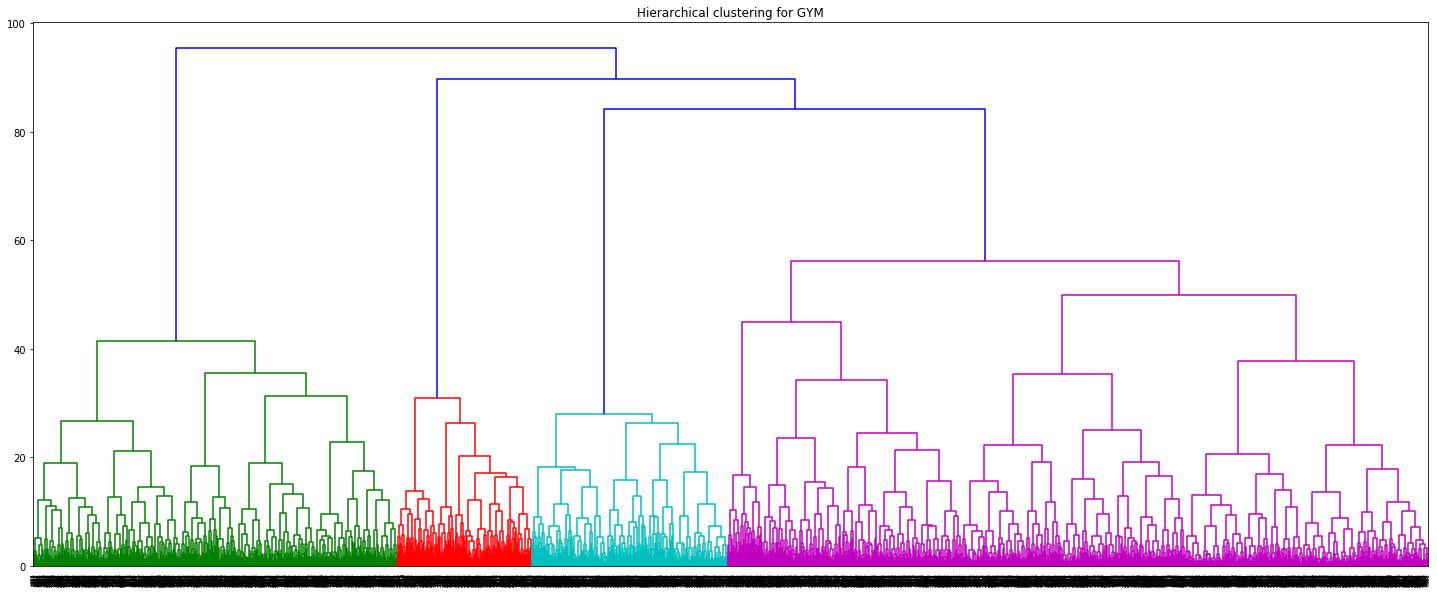

In [264]:
# standardizing the data
x_sc = scaler.fit_transform(X)

linked = linkage(x_sc, method='ward') 

# create a dendrogram
plt.figure(figsize=(25, 10))  
dendrogram(linked)
plt.title('Hierarchical clustering for GYM')
plt.show()

### Train the clustering model

In [265]:
# defining the K_means models with 5 clusters and predict clusters
km = KMeans(n_clusters = 5, random_state=0) 
labels = km.fit_predict(x_sc)

**Conclusion**

The dendrogram suggests that there are 4 optimal clusters. Neverthelss, the subsequently applied k-Means algorithm will choose k=5.

[<a href="#Table-of-contents">Back to top</a>]

### Look at the mean feature values for clusters

In [266]:
# storing cluster labels in the field of oyr dataset
churn_data['cluster_km'] = labels

# getting the statistics of the mean feature values per cluster
cluster_data = churn_data.groupby('cluster_km').mean().reset_index()
display(data_grouped)

,cluster_km,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,0,0.502370,0.949447,0.829384,0.998420,1.0,3.097946,0.448657,29.104265,141.774338,2.887836,3.772512,1.770536,1.669581,0.246445
1,1,0.554556,0.849269,0.263217,0.052868,1.0,2.606299,0.436445,30.008999,159.774261,2.419573,4.780652,2.745505,2.733173,0.089989
2,2,0.499422,0.937572,0.737572,0.478613,1.0,11.854335,0.546821,29.905202,163.509811,10.812717,4.677457,2.006405,1.998179,0.021965
3,3,0.485738,0.718011,0.299919,0.018745,1.0,1.914425,0.276284,28.083945,129.496414,1.821516,2.195599,1.225192,0.967966,0.572942
4,4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208176,4.466321,3.940415,1.854210,1.723967,0.266839


**Conclusion**

Clusters 0 and 2 have the highest mean in terms of near location. On Average, Cluster 0 had the most partners, and promo friends. The average age in all the clusters are almost the same (between 29 to 30 years). Customers in cluster 2 has the longest contract (about 12 months) on average and they stay longer than the others. Customers in cluster 3 has the least( about 2 months). Customers in cluster 3 do not stay longer (the least).

Those clusters with the highest churn rate have lower average class frequencies, lowertime, shorter contract periods, and less referrals from friends. 

[<a href="#Table-of-contents">Back to top</a>]

### Plot distributions of features for each cluster

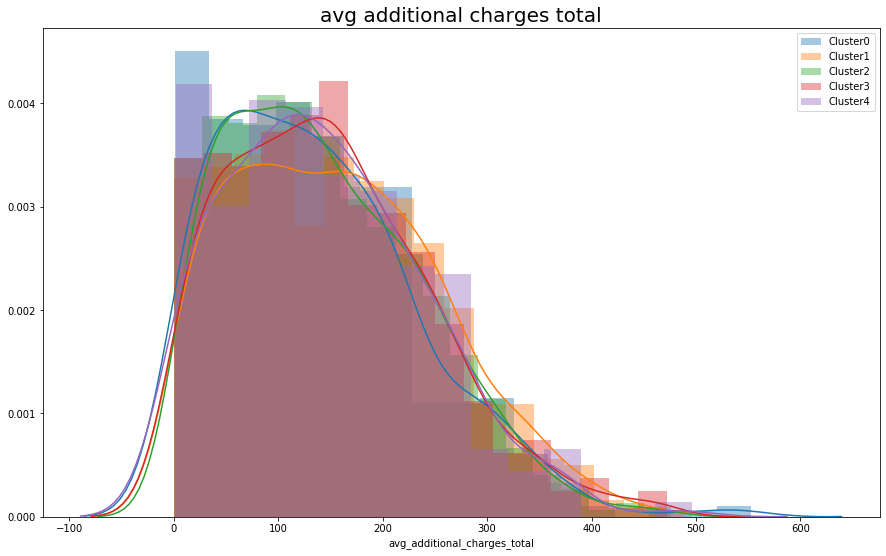

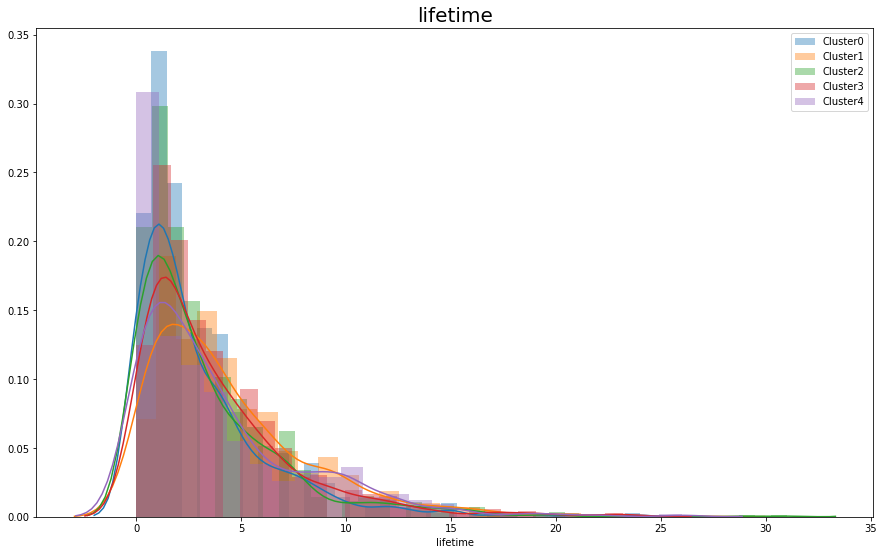

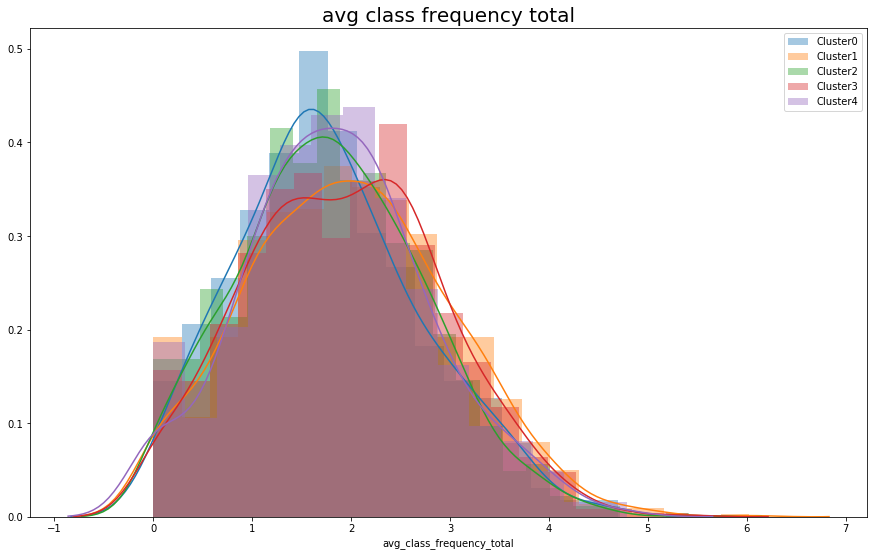

In [267]:
# plotting distributions of features for all 5 clusters
data_select= churn_data[['age','avg_additional_charges_total', 'lifetime','avg_class_frequency_total', 'cluster_km', 'churn']]

for j in range(0, len(data_select.drop(['cluster_km', 'churn'], axis=1).columns)):
    colname = list(data_select.columns)[j+1]
    if colname != 'cluster_km':
        fig, ax = plt.subplots(figsize = (15, 9))
        for i in range(0, 5):
            subset = data_select.query('cluster_km == @i')
            rel = subset[colname]
            ax = sns.distplot(rel, label='Cluster' +str(i))
        ax.legend()
        ax.set_title(colname.replace('_', ' '), size=20)
        plt.show()

**Conclusion**

Average additional charges and lifetime for the clusters are right skewed. Average class frequency total is approximately normally distributed for all clusters.

[<a href="#Table-of-contents">Back to top</a>]

### Calculate the churn rate for each cluster

In [268]:
# calculating churn rate for each cluster
cluster_churn = churn_data.query("churn ==1")

churn_rate = (cluster_churn.groupby('cluster_km')["churn"].count()
              /churn_data.groupby('cluster_km')["churn"].count()).reset_index().rename(columns={"cluster_km": "clusters", "churn": "churn rate"})
display(churn_rate.sort_values(by='churn rate', ascending=False))

,clusters,churn rate
0,0,0.399287
2,2,0.381625
4,4,0.266839
3,3,0.200918
1,1,0.120952


**Conclusion**

As we can see, cluster 0 and 2 have the highest risk to churn, while cluster 1 have the lowest risk. From our observation, we can conclude that we should invest resources based on the churn rates in descending order.

[<a href="#Table-of-contents">Back to top</a>]

## Step 5. Conclusions and basic recommendations

**Conclusion**

After carrying out exploratory analysis and machine learning analysis, we discovered that...

* Churn customers are on average 27 years old, while non-churn customers are on average 30 years old. 
* Non-churn clients have an average lifetime of roughly 5 months, while churn customers have an average lifetime of less than a month. 
* Customers who stayed paid an average of 158.45 dollars more in total additional charges than those who left (about 115.08).
* The share of gender, age, whether users provided their phone number, and whether users live near the gym do not vary much between churn and non-churn customers ( that is, the share is almost the same). But generally, customers who live near the gym are five times more than customers who do not for both group.
* Every other features apart from gender are negatively correlated with the target variable (churn). 
* Out of 602 non-churn customers in the validation data, the model correctly predicted 559 of them (True positive), and wrongly predicted 43 of them (False positive ). Out of the 198 churn customers in the validation data, the model correctly predicted 160 (True positive), and wrongly predicted 38 of them (False negative).
* Clusters 2 and 0 have the highest mean in terms of near location. On Average, Cluster 0 had the most partners, and promo friends. The average age in all the clusters are almost the same (between 29 to 30 years). Customers in cluster 2 has the logest contract (about 12 months) on average and they stay longer than the others. Customers in cluster 3 has the least( about 2 months). Customers in cluster 3 do not stay longer (the least).
* Those clusters with the highest churn rate have lower average class frequencies, lowertime, shorter contract periods, and less referrals from friends.
* Younger people are more likely to churn than older people.
* There are optimally 4 cluster of customers.
* Churn rates differ among clusters. Clusters 0 and 2 are more prone to leaving, clusters 1 are more loyal.


**Recommendation**

* We should encourage customers to attend group sessions and renew their contracts for longer periods before the current contract's expiration.
* Pay much attention to customers in Clusters 0 and 2 as they are more prone to leaving.
* Introduce loyalty programs, maybe instead of offering 1 month as minimum contract period, we could offer 3 months since those with a 1-month contract are more likely to churn.
* We should consider offering younger customers lower fees as their rate of leaving might be due to lower financial capability.
* We should focus on building new gym branches closer to people's homes if the need arises, so it will be more convenient for them to get to the gym and reduce the churn rate.

[<a href="#Table-of-contents">Back to top</a>]